# Chapter 6: Probability Density Functions (PDF)


The derivative of a CDF is called a **probability density function**, or PDF. For example, the PDF of an exponential distribution is:

![alt text](notebookpics/derived_pdf.png "Title")

Evaluating a PDF for a particular value of x is usually not useful. The result is not a probability; it is a probability density.

In physics, density is mass per unit of volume; in order to get a mass, you have to multiply by volume or, if the density is not constant, you have to integrate over volume.

Similarly, **probability density** measures probability per unit of x. In order to get a probability mass, you have to integrate over x. `thinkstats2` provides a class called `Pdf` that represents a probability density
function. Every `Pdf` object provides the following methods:

- `Density`, which takes a value, x, and returns the density of the distribution at x.
- `Render`, which evaluates the density at a discrete set of values and returns a pair of sequences: the sorted values, xs, and their probability densities, ds.
- `MakePmf`, which evaluates Density at a discrete set of values and returns a normalized Pmf that approximates the Pdf.
- `GetLinspace`, which returns the default set of points used by Render and MakePmf.

`Pdf` is an abstract parent class, which means you should not instantiate it; that is, you cannot create a `Pdf` object. Instead, you should define a child class that inherits from `Pdf` and provides definitions of `Density` and `GetLinspace`. `Pdf` provides `Render` and `MakePmf`.

For example, `thinkstats2` provides a class named `NormalPdf` that evaluates the normal density function.

```python
    class NormalPdf(Pdf):
        def __init__(self, mu=0, sigma=1, label=''):
            self.mu = mu
            self.sigma = sigma
            self.label = label
            
        def Density(self, xs):
            return scipy.stats.norm.pdf(xs, self.mu, self.sigma)
        
        def GetLinspace(self):
            low, high = self.mu-3*self.sigma, self.mu+3*self.sigma
            return np.linspace(low, high, 101)
```

The `NormalPdf` object contains the parameters mu and sigma. Density uses `scipy.stats.norm`, which is an object that represents a normal distribution and provides `cdf` and `pdf`, among other methods.

The following example creates a `NormalPdf` with the mean and variance of adult female heights, in cm, from the `BRFSS`. Then it computes the density of the distribution at a location one standard deviation from the mean.

In [13]:
import thinkstats2
import math
import thinkplot
import random
import numpy as np
import matplotlib.pyplot as plt

In [3]:
mean, var = 163, 52.8
std = math.sqrt(var)
pdf = thinkstats2.NormalPdf(mean, std)
pdf.Density(mean + std)

0.033300124989618714

The result is about `0.03`, in units of probability mass per cm. Again, a probability density doesn’t mean much by itself. But if we plot the Pdf, we can see the shape of the distribution:

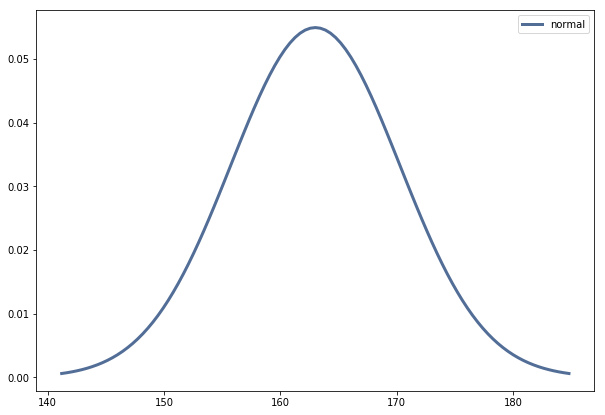

<Figure size 576x432 with 0 Axes>

In [8]:
plt.figure(figsize=(10,7))
thinkplot.Pdf(pdf, label='normal')
thinkplot.Show()

`thinkplot.Pdf` plots the Pdf as a smooth function, as contrasted with `thinkplot.Pmf`, which renders a Pmf as a step function.

You can use `MakePmf` to approximate the Pdf:

```python
pmf = pdf.MakePmf()
```

Create a pmf using this method using the adult female heights, in cm, from the `BRFSS`:

In [9]:
from Thinkstats2 import brfss
df = brfss.ReadBrfss(filename='Thinkstats2/CDBRFS08.ASC.gz')
height = df.htm3.dropna()

By default, the resulting `Pmf` contains 101 points equally spaced from mu - 3*sigma to mu + 3*sigma. Optionally, `MakePmf` and `Render` can take keyword arguments `low`, `high` and `n`.

`thinkplot` provides `Pdf`, which plots the probability density with a smooth curve.

Create a pdf with `thinkstats2.NormalPdf()` of the female heights:

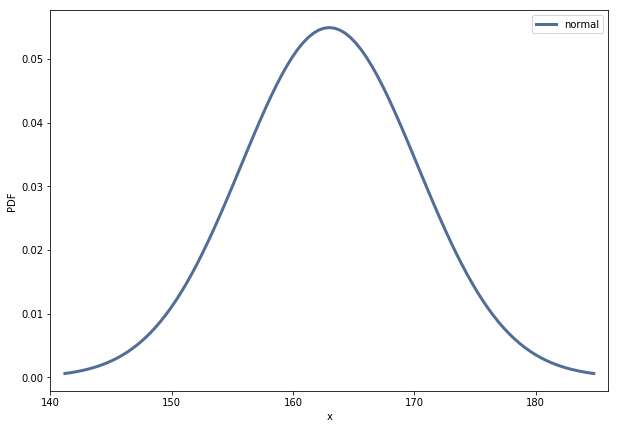

In [10]:
plt.figure(figsize=(10,7))
thinkplot.Pdf(pdf, label='normal')
thinkplot.Config(xlabel='x', ylabel='PDF', xlim=[140, 186])

`Pdf` provides `MakePmf`, which returns a `Pmf` object that approximates the `Pdf`. 

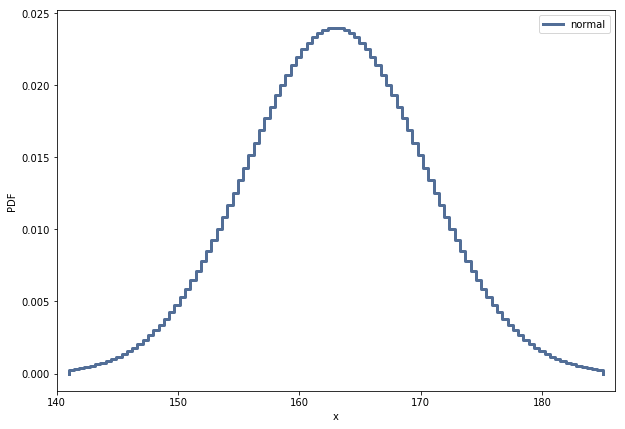

In [11]:
pmf = pdf.MakePmf()
plt.figure(figsize=(10,7))
thinkplot.Pmf(pmf, label='normal')
thinkplot.Config(xlabel='x', ylabel='PDF', xlim=[140, 186])

If you have a `Pmf`, you can also plot it using `Pdf`, if you have reason to think it should be represented as a smooth curve.

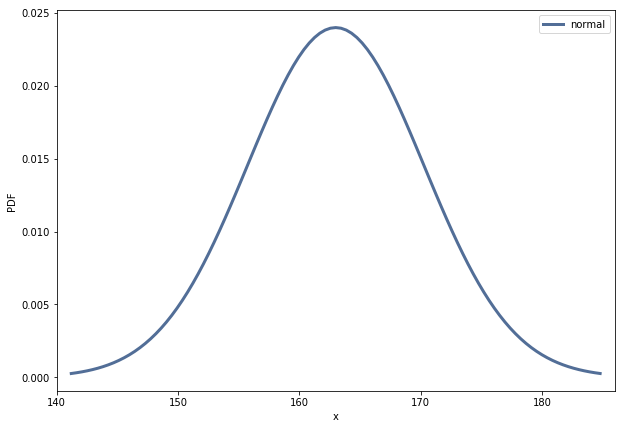

In [12]:
plt.figure(figsize=(10,7))
thinkplot.Pdf(pmf, label='normal')
thinkplot.Config(xlabel='x', ylabel='PDF', xlim=[140, 186])

## Kernel density estimation

**Kernel density estimation (KDE)** is an algorithm that takes a sample and finds an appropriately smooth PDF that fits the data. You can read details at http://en.wikipedia.org/wiki/Kernel_density_estimation.

`Scipy` provides an implementation of KDE and `thinkstats2` provides a class called `EstimatedPdf` that uses it:

```python
class EstimatedPdf(Pdf):
    def __init__(self, sample):
        self.kde = scipy.stats.gaussian_kde(sample)
    def Density(self, xs):
        return self.kde.evaluate(xs)
```

'`_init__` Takes a sample and computes a kernel density estimate. The result is a `gaussian_kde` object that provides an evaluate method.

`Density` takes a value or sequence, calls `gaussian_kde.evaluate`, and returns the resulting density. The word “Gaussian” appears in the name because it uses a filter based on a Gaussian distribution to smooth the KDE.

Here’s an example that generates a sample from a normal distribution and then makes an `EstimatedPdf` to fit it:

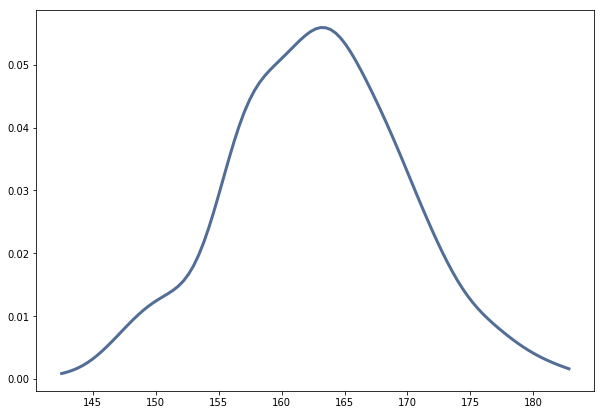

In [14]:
sample = [random.gauss(mean, std) for i in range(500)]
sample_pdf = thinkstats2.EstimatedPdf(sample)
plt.figure(figsize=(10,7))
thinkplot.Pdf(sample_pdf, label='sample KDE')

sample is a list of 500 random heights. `sample_pdf` is a Pdf object that contains the estimated KDE of the sample.

Using a sample from the actual distribution, we can estimate the PDF using Kernel Density Estimation (KDE).

If you run this a few times, you'll see how much variation there is in the estimate.

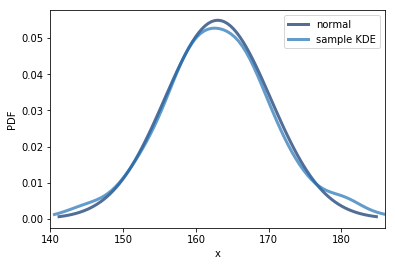

In [28]:
thinkplot.Pdf(pdf, label='normal')

sample = np.random.normal(mean, std, 500)
sample_pdf = thinkstats2.EstimatedPdf(sample, label='sample')
thinkplot.Pdf(sample_pdf, label='sample KDE')
thinkplot.Config(xlabel='x', ylabel='PDF', xlim=[140, 186])

This figure shows the normal density function and a KDE based on a sample of 500 random heights. The estimate is a good match for the original distribution.

Estimating a density function with KDE is useful for several purposes:
- Visualization: During the exploration phase of a project, CDFs are usually the best visualization of a distribution. After you look at a CDF, you can decide whether an estimated PDF is an appropriate model of the distribution. If so, it can be a better choice for presenting the distribution to an audience that is unfamiliar with CDFs.
- Interpolation: An estimated PDF is a way to get from a sample to a model of the population. If you have reason to believe that the population distribution is smooth, you can use KDE to interpolate the density for values that don’t appear in the sample.
- Simulation: Simulations are often based on the distribution of a sample. If the sample size is small, it might be appropriate to smooth the sample distribution using KDE, which allows the simulation to explore more possible outcomes, rather than replicating the observed data.

## The distribution framework

At this point we have seen PMFs, CDFs and PDFs; let’s take a minute to review.

We started with PMFs, which represent the probabilities for a discrete set of values. To get from a PMF to a CDF, you add up the probability masses to get cumulative probabilities. To get from a CDF back to a PMF, you compute
differences in cumulative probabilities. We’ll see the implementation of these operations in the next few sections.

A PDF is the derivative of a continuous CDF; or, equivalently, a CDF is the integral of a PDF. Remember that a PDF maps from values to probability densities; to get a probability, you have to integrate.

To get from a discrete to a continuous distribution, you can perform various kinds of smoothing. One form of smoothing is to assume that the data come from an analytic continuous distribution (like exponential or normal) and
to estimate the parameters of that distribution. Another option is kernel density estimation.

The opposite of smoothing is **discretizing**, or quantizing. If you evaluate a PDF at discrete points, you can generate a PMF that is an approximation of the PDF. You can get a better approximation using numerical integration.

To distinguish between continuous and discrete CDFs, it might be better for a discrete CDF to be a “cumulative mass function,” but as far as I can tell no one uses that term.

![alt text](notebookpics/Distribution_relationship.png "Title")

## Hist implementation

At this point you should know how to use the basic types provided by thinkstats2: Hist, Pmf, Cdf, and Pdf. The next few sections provide details about how they are implemented. This material might help you use these classes more effectively, but it is not strictly necessary.

Hist and Pmf inherit from a parent class called `_DictWrapper`. **The leading underscore indicates that this class is “internal” that is, it should not be used by code in other modules.** The name indicates what it is: a dictionary wrapper. Its primary attribute is d, the dictionary that maps from values to their frequencies.

The values can be any hashable type. The frequencies should be integers, but can be any numeric type.

`_DictWrapper` contains methods appropriate for both Hist and Pmf, including `__init__`, `Values`, `Items` and `Render`. It also provides modifier methods Set, Incr, Mult, and Remove. These methods are all implemented with dictionary operations. For example:
```python
class _DictWrapper
    def Incr(self, x, term=1):
        self.d[x] = self.d.get(x, 0) + term
    def Mult(self, x, factor):
        self.d[x] = self.d.get(x, 0) * factor
    def Remove(self, x):
        del self.d[x]
```

Hist also provides Freq, which looks up the frequency of a given value. 

Because Hist operators and methods are based on dictionaries, these methods are constant time operations; that is, their run time does not increase as the Hist gets bigger.

`Find the hist and pmf class in the code, within them find the previous methods shown`


## PMF implementation

Pmf and Hist are almost the same thing, except that a Pmf maps values to floating-point probabilities, rather than integer frequencies. If the sum of the probabilities is 1, the Pmf is normalized.

Pmf provides Normalize, which computes the sum of the probabilities and divides through by a factor:

```python
class Pmf:
    def Normalize(self, fraction=1.0):
        total = self.Total()
    if total == 0.0:
        raise ValueError('Total probability is zero.')
        factor = float(fraction) / total
    for x in self.d:
        self.d[x] *= factor
    return total
```

**Write down the logic of the PMF class**

here

fraction determines the sum of the probabilities after normalizing; the default value is 1. If the total probability is 0, the Pmf cannot be normalized, so Normalize raises ValueError.

Hist and Pmf have the same constructor. It can take as an argument a dict, Hist, Pmf or Cdf, a pandas Series, a list of (value, frequency) pairs, or a sequence of values.

If you instantiate a Pmf, the result is normalized. If you instantiate a Hist, it is not. To construct an unnormalized Pmf, you can create an empty Pmf and modify it. The Pmf modifiers do not renormalize the Pmf.

## Cdf implementation

A CDF maps from values to cumulative probabilities, so I could have implemented Cdf as a `_DictWrapper`. But the values in a CDF are ordered and the values in a `_DictWrapper` are not. Also, it is often useful to compute the
inverse CDF; that is, the map from cumulative probability to value. So the implementaion I chose is two sorted lists. That way I can use binary search to do a forward or inverse lookup in logarithmic time.

The Cdf constructor can take as a parameter a sequence of values or a pandas Series, a dictionary that maps from values to probabilities, a sequence of (value, probability) pairs, a Hist, Pmf, or Cdf. Or if it is given two parameters, it treats them as a sorted sequence of values and the sequence of corresponding cumulative probabilities.

Given a sequence, pandas Series, or dictionary, the constructor makes a Hist. Then it uses the Hist to initialize the attributes:
```python
    self.xs, freqs = zip(*sorted(dw.Items()))
    self.ps = np.cumsum(freqs, dtype=np.float)
    self.ps /= self.ps[-1]
   ```
xs is the sorted list of values; freqs is the list of corresponding frequencies. np.cumsum computes the cumulative sum of the frequencies. Dividing through by the total frequency yields cumulative probabilities. For n values,
the time to construct the Cdf is proportional to n log n. Here is the implementation of Prob, which takes a value and returns its cumulative probability:

```python
class Cdf
    def Prob(self, x):
        if x < self.xs[0]:
            return 0.0
        index = bisect.bisect(self.xs, x)
        p = self.ps[index - 1]
        return p
```

The bisect module provides an implementation of binary search. And here is the implementation of Value, which takes a cumulative probability and returns the corresponding value:

```python
class Cdf
    def Value(self, p):
        if p < 0 or p > 1:
            raise ValueError('p must be in range [0, 1]')
            
        index = bisect.bisect_left(self.ps, p)
        return self.xs[index]
```

Given a Cdf, we can compute the Pmf by computing differences between consecutive cumulative probabilities. If you call the Cdf constructor and pass a Pmf, it computes differences by calling Cdf.Items:
```python
class Cdf
    def Items(self):
        a = self.ps
        b = np.roll(a, 1)
        b[0] = 0
        return zip(self.xs, a-b)
```

np.roll shifts the elements of a to the right, and “rolls” the last one back to the beginning. We replace the first element of b with 0 and then compute the difference a-b. The result is a NumPy array of probabilities. Cdf provides Shift and Scale, which modify the values in the Cdf, but the probabilities should be treated as immutable.

Create a use and show the application of `np.roll`, `bisect.bisect`, `bisect.bisect_left`.

In [29]:
# Code here

## Moments

Any time you take a sample and reduce it to a single number, that number is a statistic. The statistics we have seen so far include mean, variance, median, and interquartile range.

A **raw moment** is a kind of statistic. If you have a sample of values, x i , the kth raw moment is:

![alt text](notebookpics/central_moment.png "Title")

Implement it in python:


In [ ]:
# Code here

When k = 1 the result is the sample mean, x̄. The other raw moments don’t mean much by themselves, but they are used in some computations.

The **central moments** are more useful. The kth central moment is:

![alt text](notebookpics/moment_raw.png "Title")

Implement it in python:

In [30]:
# Code here

When k = 2 the result is the second central moment, which you might recognize as variance. The definition of variance gives a hint about why these statistics are called moments. If we attach a weight along a ruler at
each location, x, and then spin the ruler around the mean, the moment of inertia of the spinning weights is the variance of the values. If you are not familiar with moment of inertia, see http://en.wikipedia.org/wiki/Moment_of_inertia.

When you report moment-based statistics, it is important to think about the units. For example, if the values x are in cm, the first raw moment is also in cm. But the second moment is in cm 2 , the third moment is in cm 3 , and
so on.

Because of these units, moments are hard to interpret by themselves. That’s why, for the second moment, it is common to report standard deviation, which is the square root of variance, so it is in the same units as x.

# Skewness
Skewness is a property that describes the shape of a distribution. If the distribution is symmetric around its central tendency, it is unskewed. If the values extend farther to the right, it is “right skewed” and if the values extend left, it is “left skewed.”

This use of “skewed” does not have the usual connotation of “biased.” Skewness only describes the shape of the distribution; it says nothing about whether the sampling process might have been biased.

Several statistics are commonly used to quantify the skewness of a distribution. Given a sequence of values, x, the **sample skewness**, g, can be computed like this:

```python
def StandardizedMoment(xs, k):
    var = CentralMoment(xs, 2)
    std = math.sqrt(var)
    return CentralMoment(xs, k) / std**k

def Skewness(xs):
    return StandardizedMoment(xs, 3)
```
g is the third **standardized moment**, which means that it has been normalized so it has no units.

Negative skewness indicates that a distribution skews left; positive skewness indicates that a distribution skews right. The magnitude of g 1 indicates the strength of the skewness, but by itself it is not easy to interpret.

In practice, computing sample skewness is usually not a good idea. If there are any outliers, they have a disproportionate effect on g.


In [ ]:
# Why?


Another way to evaluate the asymmetry of a distribution is to look at the relationship between the mean and median. Extreme values have more effect on the mean than the median, so in a distribution that skews left, the mean is
less than the median. In a distribution that skews right, the mean is greater.

**Pearson’s median skewness coefficient** is a measure of skewness based on the difference between the sample mean and median:
![alt text](notebookpics/pearson_median.png "Title")

Where x̄ is the sample mean, m is the median, and S is the standard deviation. 
Implement it in python, and calculate it for the weights of the adults for both methods we have seen:

In [36]:
# Code here

df = brfss.ReadBrfss(filename='Thinkstats2/CDBRFS08.ASC.gz', nrows=None)

Or in Python:

```python
    def Median(xs):
        cdf = thinkstats2.Cdf(xs)
        return cdf.Value(0.5)
    
    def PearsonMedianSkewness(xs):
        median = Median(xs)
        mean = RawMoment(xs, 1)
        var = CentralMoment(xs, 2)
        std = math.sqrt(var)
        gp = 3 * (mean - median) / std
        return gp```

This statistic is **robust**, which means that it is less vulnerable to the effect of outliers.

As an example, let’s look at the skewness of birth weights in the NSFG pregnancy data. Here’s the code to estimate and plot the PDF:

```python
live, firsts, others = first.MakeFrames()
data = live.totalwgt_lb.dropna()
pdf = thinkstats2.EstimatedPdf(data)
thinkplot.Pdf(pdf, label='birth weight')```

Now let’s compare this distribution to the distribution of adult weight in the BRFSS. Again, here’s the code:

```python
df = brfss.ReadBrfss(nrows=None)
data = df.wtkg2.dropna()
pdf = thinkstats2.EstimatedPdf(data)
thinkplot.Pdf(pdf, label='adult weight')```

The sign of the skewness coefficient indicates whether the distribution skews left or right, but other than that, they are hard to interpret. Sample skewness is less robust; that is, it is more susceptible to outliers. As a result it is less reliable when applied to skewed distributions, exactly when it would be most relevant.

Pearson’s median skewness is based on a computed mean and variance, so it is also susceptible to outliers, but since it does not depend on a third moment, it is somewhat more robust.

## Exercises

The distribution of income is famously skewed to the right. In this exercise, we’ll measure how strong that skew is.
The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file you will find in the repository for this book. You will also find `hinc2.py`, which reads this file and transforms the data.

The dataset is in the form of a series of income ranges and the number of respondents who fell in each range. The lowest range includes respondents who reported annual household income “Under \$5000.” The highest range includes respondents who made “\$250,000 or more.”

To estimate mean and other statistics from these data, we have to make some assumptions about the lower and upper bounds, and how the values are distributed in each range. `hinc2.py` provides `InterpolateSample`, which shows one way to model this data. It takes a `DataFrame` with a column, `income`, that contains the upper bound of each range, and `freq`, which contains the number of respondents in each frame.

It also takes `log_upper`, which is an assumed upper bound on the highest range, expressed in `log10` dollars. The default value, `log_upper=6.0` represents the assumption that the largest income among the respondents is $10^6$, or one million dollars.

`InterpolateSample` generates a pseudo-sample; that is, a sample of household incomes that yields the same number of respondents in each range as the actual data. It assumes that incomes in each range are equally spaced on a `log10` scale.

In [29]:
def InterpolateSample(df, log_upper=6.0):
    """Makes a sample of log10 household income.

    Assumes that log10 income is uniform in each range.

    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range

    returns: NumPy array of log10 household income
    """
    # compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)

    # get the lower bounds by shifting the upper bound and filling in
    # the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0

    # plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    # use the freq column to generate the right number of values in
    # each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, row.freq)
        arrays.append(vals)

    # collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample


In [30]:
import hinc
income_df = hinc.ReadData()

In [31]:
log_sample = InterpolateSample(income_df, log_upper=6.0)

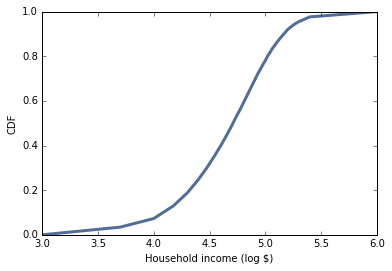

In [32]:
log_cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(log_cdf)
thinkplot.Config(xlabel='Household income (log $)',
               ylabel='CDF')

In [33]:
sample = np.power(10, log_sample)

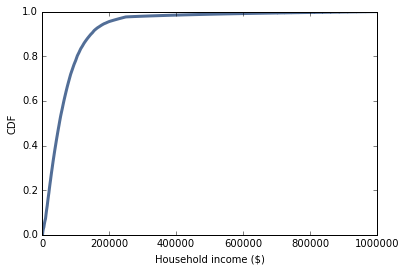

In [34]:
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)',
               ylabel='CDF')

Compute the median, mean, skewness and Pearson’s skewness of the resulting sample. What fraction of households report a taxable income below the mean? How do the results depend on the assumed upper bound?

In [37]:
# Solution

In [38]:
# Solution

In [39]:
# Solution

All of this is based on an assumption that the highest income is one million dollars, but that's certainly not correct.  What happens to the skew if the upper bound is 10 million?

Without better information about the top of this distribution, we can't say much about the skewness of the distribution.